###  Embarassingly parallel jobs with Job lib

Even though task of parallelism is often a complicated one, considering the fact that the code has to be analyzed for which part of it can be executed parallely and which cannot be parallelized and also the availaible resources have to be taken into consideration.

There is also the problem of "diminishing returns" as exhibited by Amaldahl's law where allocating more resources might lead to lesser performance.

Parallel jobs have to take care of synchronizations as well. 

Below we explore the job lib library to perform some very simple performance improvization using parallization.

Joblib performs "embaressingly parralel jobs" whuch implies one parallel task has absolutely no dependency amongst each other.

In [1]:
import os

In [2]:
os.cpu_count()

8

#### Observation

The system has 4 cores , due to hyperthreading each processor can allocate its resources to 2 different threads

hyperthreading : Intel's proprietary simultaneous multithreading implementation.Hyper threading would allow a single processor core to be considered as multiple virtual cores i.e it uses the concept of context switching, would allow a job to use up the processor's resouces when another job is on stall say due to IO operations.



In [3]:
from joblib import Parallel,delayed

In [4]:
import time,math

In [5]:
import matplotlib.pyplot as plt

In [7]:
import numpy as np

In [8]:
def func_to_check_with1(size_of_array):
    'Convolve 2 random arrays of given size'
    array1 = np.random.random_sample(size_of_array)
    array2 = np.random.random_sample(size_of_array)
    return np.convolve(array1 , array2)


In [9]:
def run_func_serial(func,param, iterations):
    start = time.time()
    
    for iteration in range(iterations):
        func(param+iteration)
    
    end = time.time()
    
    return (end-start)

In [10]:
def run_func_parallel(func,param,iterations,backend,n_jobs,verbose,with_delayed=True):
    start = time.time()
    
    if with_delayed == True:
        
        Parallel(n_jobs = n_jobs,verbose = verbose,backend=backend)(
            delayed(func)(param+iteration) for iteration in range(iterations)
        )
        
    else :
        Parallel(n_jobs = n_jobs,verbose = verbose,backend=backend)(
            func(param+iteration) for iteration in range(iterations)
        )
        

    end = time.time()
    
    return (end-start)

    
    

#### Observing Multi threading overhead

In [11]:
run_func_parallel(func_to_check_with1,param=10,iterations=5,backend='loky',n_jobs=2,verbose=50)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.6s finished


0.6881716251373291

In [12]:
run_func_serial(func_to_check_with1,param = 10,iterations=5)

0.0009963512420654297

Clearly the multithreading overhead is higher

In [13]:
run_func_parallel(func_to_check_with1,param=40000,iterations=10,backend='loky',n_jobs=4,verbose=50)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done   4 out of  10 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.6s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed:    2.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.3s finished


3.49834942817688

In [14]:
run_func_serial(func_to_check_with1,param=40000,iterations=5)

9.876240253448486

There you go!!

#### Comparing the time taken by creating different numbers of processes for default backend

In [15]:
list_of_time = []

for n_process in range(1,50):
    list_of_time.append(run_func_parallel(func_to_check_with1,param=40000,iterations=10,backend='loky',n_jobs=n_process,verbose=1))
    
    
    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=7)]: Using backend LokyBack

In [33]:
serial_time = run_func_serial(func_to_check_with1,param=40000,iterations=10)

In [36]:
list_of_serial_time = [serial_time]*49

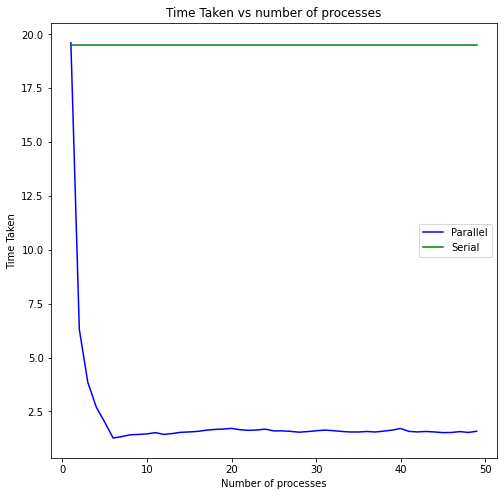

In [39]:
plt.figure(figsize=(8,8))
plt.title('Time Taken vs number of processes')
plt.xlabel('Number of processes')
plt.ylabel('Time Taken')

plt.plot(range(1,50),list_of_time,color ='b')
plt.plot(range(1,50),list_of_serial_time,color = 'g')
plt.legend(['Parallel','Serial'])
plt.show()

#### Observation

True to Amaldahl's law (law of diminishing returns) there is no further improvement (reduction in time taken) after n_jobs=8 (nos of cores availaible to us) , infact there is aslight increase in the time taken as the lowest time taken is acheived at n_jobs = 8

#### Use of delayed

Delayed is a decorator which is essential forjjoblib parrallel to run. Without delayed decorator before the task can be divided amongst parallel threads the task gets executed and thus essentialy there is no more parallelism to happen

Running with delayed throws expection from joblib parallelism with "too many values to unpack" , which as per my understanding is due to the fact that the entire list of tasks is executed and returned to Parallel rather than one task at a time (do feel free to correct me if my understanding is wrong)

#### Multiprocessing vs Multithreading

*Since the multiprocessing falis in jupyter, the plot for the below are attached as seperated file "Plot for Multiprocessing vs multithreading" in the repo*

In [ ]:
run_func_parallel(func_to_check_with1,param=400,iterations=5,backend='multiprocessing',n_jobs=2,verbose=1)

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.


In [ ]:
##multiprocessing

list_of_time_multiprocess = []

for n_process in range(1,9):
    list_of_time_multiprocess.append(run_func_parallel(func_to_check_with1,param=40000,iterations=5,backend='multiprocessing',n_jobs=n_process,verbose=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.


In [13]:
##multithreading

list_of_time_multithreading = []

for n_process in range(1,9):
    list_of_time_multithreading.append(run_func_parallel(func_to_check_with1,param=40000,iterations=5,backend='threading',n_jobs=n_process,verbose=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=7)

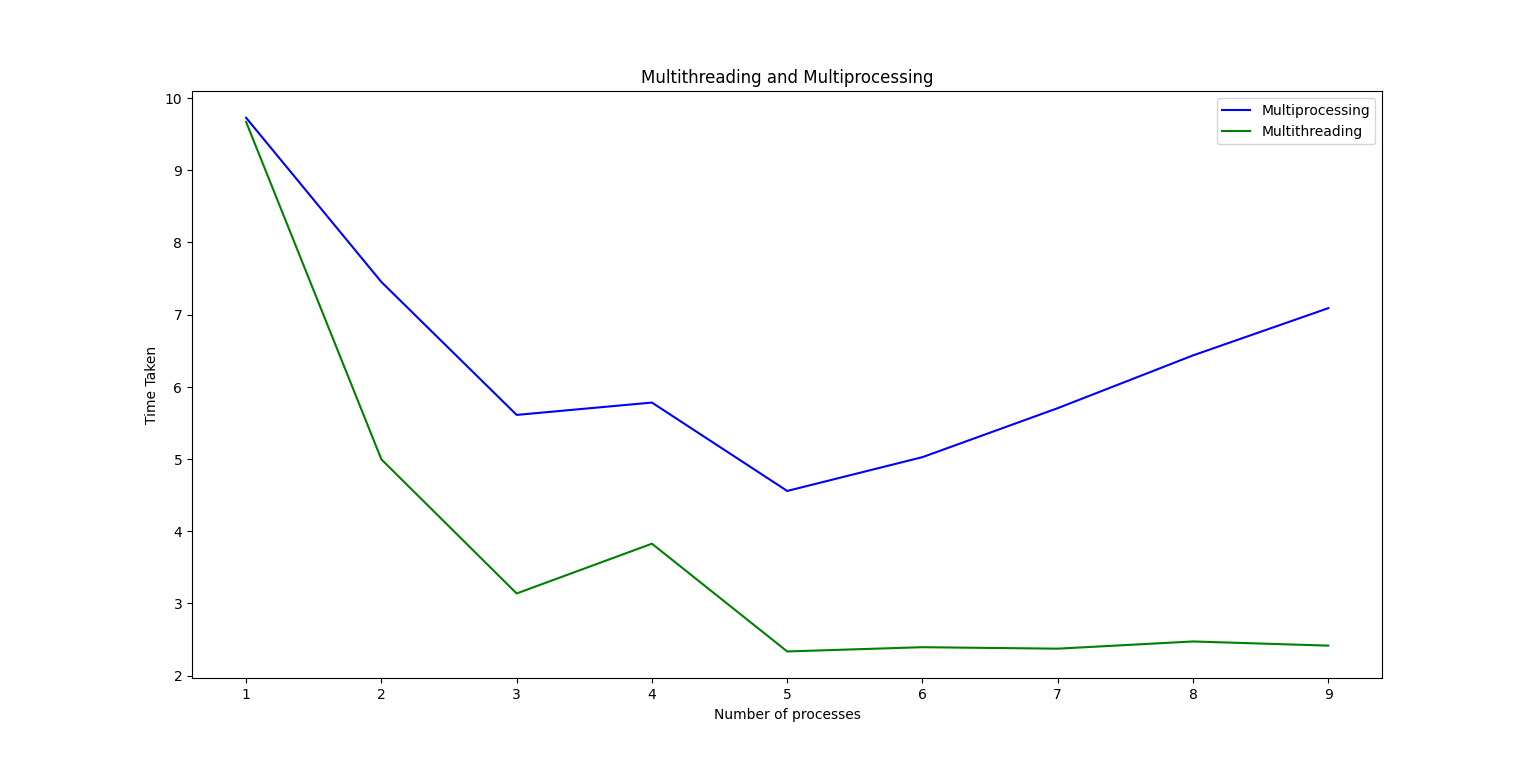

In [2]:
## since we could not run multiprocessing in ipynb in windows , it was run as a script to obtain the output
from IPython import display

display.Image("./MultiThreading_Multiprocessing.png")

#### Observation

Clearly multithreading take significantly less amount of time as compared to multiprocessing .

This happens because we are currently in a single processor system and multithreading allows to create multiple threads for a single process. Threads by defination are light wright processes and hence has significantly less overhead. 

Each process created during multiprocessing must have its own set of registers ,stack and takes time for intercommunication as well unlike threads which belongs to a single process and gets to share the resources